In [1]:
%matplotlib inline
    
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from typing import Dict, List, NamedTuple, Tuple

Voter = str
Choice = str

class Decision(NamedTuple):
    name: str
    preference: List[Choice]
    weight: int

def borda_scoring(decision: List[Choice], choices: List[Choice]) -> List[Tuple[str, int]]:
    return [(ch, len(choices) - decision.index(ch)) for ch in choices]

def plot_decisions(decisions: List[Decision], 
                   choices: List[Choice]):
    """有権者の順序付を受け取って、単峰性が見やすいようにプロットします"""
    fig, ax = plt.subplots()
    for decision in decisions:
        scores = borda_scoring(decision.preference, choices)
        xs, ys = zip(*scores)
        ax.plot(xs, ys, marker="o")
    ax.set_xticks(choices)
    ax.set_xticklabels(["$" + ch + "$" for ch in choices], color="k", size=20)
    ax.set_yticks([i + 1 for i in range(len(choices))])
    names = [dcsn.name for dcsn in decisions]
    ax.legend(names, bbox_to_anchor =(0.75, 1.15), ncol=3)


In [3]:
from itertools import combinations


def eval_decisions(decisions: List[Decision],
                    choices: List[Choice], eval_func):
    _eval = lambda d:  eval_func(d, choices)
    decision_arr = np.array([_eval(decision.preference) for decision in decisions])
    decision_arr = decision_arr[:,:,1].transpose().astype(int)
    return decision_arr


def global_pairwise_winner(decisions: List[Decision],
                           choices: List[Choice], eval_func):
    decision_arr = eval_decisions(decisions, choices, eval_func)
    polls = {}
    match_table = np.zeros(shape=[3,3])
    for pair in list(combinations(choices, 2)):
        indices = [choices.index(pair[0]), choices.index(pair[1])]
        poll = np.array([(s1 > s2, s1 < s2) for s1, s2 in zip(*decision_arr[indices])])
        poll = np.matmul(np.array([decision.weight for decision in decisions]), poll)
        poll = list(poll)
        polls[pair] = poll        
        match_table[indices[0], indices[1]] = poll[0] > poll[1]
        match_table[indices[1], indices[0]] = poll[1] > poll[0]
    winners = np.array(choices)[match_table.sum(axis=1) == len(choices) - 1]
    losers = np.array(choices)[match_table.sum(axis=1) == 0]    
    return winners, losers, polls, match_table


def eval_borda(decisions: List[Decision],
                 choices: List[Choice], eval_func):
    decision_arr = eval_decisions(decisions, choices, eval_func)
    decision_arr *= np.array([decision.weight for decision in decisions])    
    return {choice: score for choice, score in zip(choices, decision_arr.sum(axis=1))}

# 第４章　政治と選択

## 単峰的順序とペア全勝者の存在

下の投票状況に対し、選択肢を横軸にし、その順位を縦軸にして、それぞれの有権者の順序付けをプロットする。

In [4]:
choices = ["c_0", "c_1", "c_2"]
decisions = [Decision("Satou", [choices[0], choices[1], choices[2]], 1),
            Decision("Takahashi", [choices[1], choices[2], choices[0]], 1),
            Decision("Nakano", [choices[2], choices[0], choices[1]], 1)]
decisions

[Decision(name='Satou', preference=['c_0', 'c_1', 'c_2'], weight=1),
 Decision(name='Takahashi', preference=['c_1', 'c_2', 'c_0'], weight=1),
 Decision(name='Nakano', preference=['c_2', 'c_0', 'c_1'], weight=1)]

In [5]:
def render_to_latex(decisions: List[Decision]):
    return [Decision(dcsn.name, ["$" + e + "$" for e in dcsn.preference], dcsn.weight) for dcsn in decisions]

In [6]:
df = pd.DataFrame({dcsn.name: dcsn.preference for dcsn in render_to_latex(decisions)},index=["1位", "2位", "3位"])
df

,Satou,Takahashi,Nakano
1位,$c_0$,$c_1$,$c_2$
2位,$c_1$,$c_2$,$c_0$
3位,$c_2$,$c_0$,$c_1$


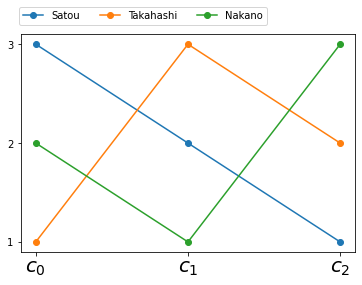

In [7]:
plot_decisions(decisions, choices)

In [8]:
winners, losers, polls, match_table = global_pairwise_winner(decisions, choices, borda_scoring)
print("Pairwise winners", winners)
print("Pairwise losers", losers)
print(polls)
print(match_table)
pd.DataFrame(eval_borda(decisions, choices, borda_scoring), index=["Borda score"])

Pairwise winners []
Pairwise losers []
{('c_0', 'c_1'): [2, 1], ('c_0', 'c_2'): [1, 2], ('c_1', 'c_2'): [2, 1]}
[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]


,c_0,c_1,c_2
Borda score,6,6,6


この図の特徴は「山」と「谷」がともにあることである。

Satou、Takahashi→山

Nakano→谷

そこで、Nakano についても山になるよう、書き換える

In [9]:
decisions = [Decision("Satou", [choices[0], choices[1], choices[2]], 1),
            Decision("Takahashi", [choices[1], choices[2], choices[0]], 1),
            Decision("Nakano", [choices[2], choices[1], choices[0]], 1)]
df = pd.DataFrame({dcsn.name: dcsn.preference for dcsn in render_to_latex(decisions)},index=["1位", "2位", "3位"])
df

,Satou,Takahashi,Nakano
1位,$c_0$,$c_1$,$c_2$
2位,$c_1$,$c_2$,$c_1$
3位,$c_2$,$c_0$,$c_0$


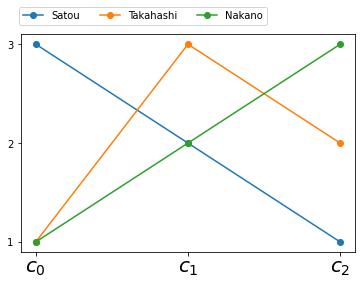

In [10]:
plot_decisions(decisions, choices)

In [11]:
winners, losers, polls, match_table = global_pairwise_winner(decisions, choices, borda_scoring)
print("Pairwise winners", winners)
print("Pairwise losers", losers)
print(polls)
print(match_table)
pd.DataFrame(eval_borda(decisions, choices, borda_scoring), index=["Borda score"])

Pairwise winners ['c_1']
Pairwise losers ['c_0']
{('c_0', 'c_1'): [1, 2], ('c_0', 'c_2'): [1, 2], ('c_1', 'c_2'): [2, 1]}
[[0. 0. 0.]
 [1. 0. 1.]
 [1. 0. 0.]]


,c_0,c_1,c_2
Borda score,5,7,6


これで、すべての有権者の順序が山型になった。

個人間で、順序が **単峰的** であるとは、誰についても1位の選択肢（これから **峰** と呼ぶ）が一つあり、そこから離れる選択肢を低く順序付ける事を意味する。

決定を行う対象によっては、順序の単峰性を仮定するのが、妥当な場合がある。
- 外交姿勢の選択肢として以下のものが考えられる。
    - $c_0$ = 穏健, $c_1$ = 中間的, $c_2$ = 強硬
    - $c_0$ = 穏健, $c_1$ = やや穏健, $c_2$ = 中間的, $c_3$ = やや強硬, $c_4$ = 強硬
    - など
- 税率
    - $c_0 = 0\%,c_1 = 2 \%, c_2 = 4 \%, c_3 = 6 \%, c_4 = 8 \%$
    - 「自分がベストと判断する選択肢が存在して、そこから離れた選択肢は好ましくない」と考えるのが自然だろう。
    - →単峰性の仮定

今、各選択肢を支持するパーセンテージが以下のようになっていると仮定する。
$$ q(c_0) = 45,\; q(c_1) = 13,\; q(c_2) = 17,\; q(c_3) = 13,\; q(c_4) = 12$$
ここで、$c_i$ が峰である有権者のパーセンテージは $q(c_i)$ である。

ここで、$c_0$ が峰の有権者は $c_1$ と $c_2$ では $c_1$ の方をより良い選択とするので、$c_1$ と $c_2$ のペア多数決をした場合、 $c_1$ が58％の支持があるので、$c_1$ が勝利する。以下は、 $c_1$ とその他の選択肢とのペア同士多数決の結果である
- 55 対 45 で、 $c_1$ が $c_0$ に勝つ
- 58 対 42 で、$c_1$ が $c_2$ に勝つ
- 58 以上 対 42 以下で、$c_1$ が $c_3$ に勝つ
- 58 以上 対 42 以下で、 $c_1$ が $c_4$ に勝つ
よって、$y$ がペア全勝者である。

この $y$ は、実は票の中位(median)に位置する選択肢である。

こうした選択肢の事を、**中位選択肢**という。

単峰性が成り立つときは、中位選択肢が必ずペア全勝者となる。この事を**中位投票者定理**という。

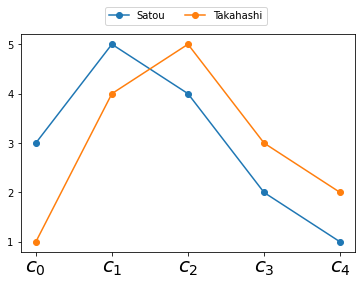

In [12]:
choices = ["c_0", "c_1", "c_2", "c_3", "c_4"]
decisions = [Decision("Satou", [choices[1], choices[2], choices[0], choices[3], choices[4]], 1),
            Decision("Takahashi", [choices[2], choices[1], choices[3], choices[4],  choices[0]], 1)]
plot_decisions(decisions, choices)

## 4.2 実証政治理論と中位投票者定理

これまでは、集約ルールを「どう作れば良いか」という設計に関わる分析を行ってきた。

→集約ルールの性質や、何が選び取られるべき選択肢であるかを考察してきた。

本節では、「何が選ばれてしまうか」という事実解明的な分析を行う。

具体的には、

- 争点は一つだけ
- 有権者間で選択肢への順序が単峰的
- 二大政党が政策競争する

この時、どのような政策が実現するかという問題を考察する(Downs, Hotelling)。

今、５つの選択肢が存在し、単峰性が成り立つと仮定する。前節と同じ

$$ q(c_0) = 45,\; q(c_1) = 13,\; q(c_2) = 17,\; q(c_3) = 13,\; q(c_4) = 12$$

という分布を考える。

ここで、二大政党 $P_0, P_1$ があったとして、彼らが政策として掲げる選択肢を選び取る状況を考えてみよう。

有権者は選挙において、自らの峰に近い方の政策を掲げる政党に票を入れるものとする。

今、一方の政党 $P_0$ が $c_1$ を、他方の政党 $P_1$ が $c_2$ を政策として掲げたとする。すると、
- $c_0$ の支持者は、$c_1$ が最も近いので、$P_0$ に投票する。よって、$P_0$ は58％の票をゲットする。
- $c_3, c_4$ の支持者は、$c_2$ が最も近いので、$P_1$ に投票する。よって、$P_1$ は42％の票をゲットする。

よって、この場合、政党 $P_0$ が勝つ。

実際、$c_1$ は、他のどの政策にも勝てる（$c_1$ はペア全勝者である）。

即ち、政策 $c_1$ を掲げた政党は必ず勝つことになる。

このことにより、両政党の政策はともに $c_1$ へ収束する。よって、両政党が同じ政策を掲げる事になり、$c_1$ は実現されることになる。

これは、二大政党の政策基本ラインが似通ったものになる事が多いことの、有力な説明となる。

二大政党による政策競争が、ペア全勝者である中位選択肢を実現させることも、中位投票者定理という。

民意の反映として、ペア全勝者を選ぶことを選挙の目的とするならば、二大政党による政策競争の機能は優れていると言える。
しかし同時にこの定理は、良くも悪くも、中位選択肢として現れる「民意」に迎合せねば選挙で勝てないという強い圧力を表すものとしても読める。

## 4.3 メカニズムデザインと中位ルール

共用スペースでの喫煙ルールを決める投票の例。

- 嫌煙者と喫煙者は逆の思惑
    - 嫌煙者は全面禁煙を望む
    - 喫煙者は少しでも喫煙可能なよう望む
- 喫煙者は、全面禁煙に対し、折衷案＝時間喫煙案を提出
    - 一部の非喫煙者が同意
- これにより、全面喫煙案に時間喫煙案が勝つ予定だった
- しかし、投票間際に、喫煙者側から3つ目の選択肢「全面喫煙」案が出される
- これにより、時間喫煙案の支持者の票が割れ、全面禁煙案が勝利した。

In [13]:
choices = ["Complete Ban", "Partial Ban", "No Ban"]
decisions = [Decision("Group A", [choices[0], choices[1], choices[2]], 4),
            Decision("Group B", [choices[1], choices[0], choices[2]], 2),
            Decision("Group C", [choices[2], choices[1], choices[0]], 3)]
df = pd.DataFrame({dcsn.name + f": {dcsn.weight}人": dcsn.preference for dcsn in decisions},index=["1位", "2位", "3位"])
df

,Group A: 4人,Group B: 2人,Group C: 3人
1位,Complete Ban,Partial Ban,No Ban
2位,Partial Ban,Complete Ban,Partial Ban
3位,No Ban,No Ban,Complete Ban


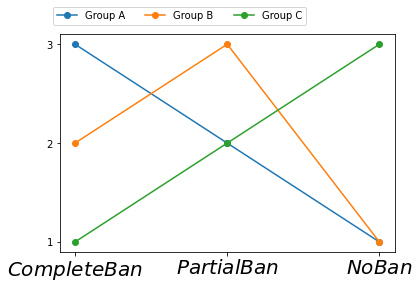

In [14]:
plot_decisions(decisions, choices)

In [15]:
winners, losers, polls, match_table = global_pairwise_winner(decisions, choices, borda_scoring)
print("Pairwise winners", winners)
print("Pairwise losers", losers)
print(polls)
print(match_table)
pd.DataFrame(eval_borda(decisions, choices, borda_scoring), index=["Borda score"])

Pairwise winners ['Partial Ban']
Pairwise losers ['No Ban']
{('Complete Ban', 'Partial Ban'): [4, 5], ('Complete Ban', 'No Ban'): [6, 3], ('Partial Ban', 'No Ban'): [6, 3]}
[[0. 0. 1.]
 [1. 0. 1.]
 [0. 0. 0.]]


,Complete Ban,Partial Ban,No Ban
Borda score,19,20,15


多数決に関する難点
- 喫煙者にとって真に望ましい選択肢である全面喫煙が新たに付け加えられたせいで、彼らにとって最も望ましくない選択肢である全面禁煙が勝ってしまった。これを**結果の逆変化**という
- 新たに $z$ が加わっても、もし $y$ を支持する非喫煙者と喫煙者が協力して $y$ に投票すれば、時間分煙を勝たせることができた。これを**戦略的操作への脆弱性**という。

これらの弱点を克服する集約ルールは存在するのか？

Yes, それは**中位ルール**だ。

中位ルールとは、各有権者は自分の峰である選択肢に投票し、その中での中位を選び取る方法である。

中位ルールでは
- 結果の逆変化が起こらない
- 戦略的操作を起こすインセンティブがない。

中位ルールのこうした性質は**耐戦略性、連立耐戦略性**という。

## 4.4 ボルダルールについての補足

単峰性が成り立つときにボルダルールについて考察することは、ほとんど行われていない。

一般に

単峰性 ⇒ ボルダ勝者＝ペア全勝者

ではない。

単峰生が成り立つときの、ボルダ勝者とペア全勝者が一致する条件は...
- 選択肢の集合が無限集合の時は与えられている
- 有限集合の場合は？
    - 多分、分かっていない。
- 単峰性が成り立つときの、ボルダルールの性質については、ほとんど明らかにされていない。

以下は、単峰性があるが、ボルダ勝者とペア全勝者が一致しない例。

In [16]:
choices = ["c_0", "c_1", "c_2"]
decisions = [Decision("Group A", [choices[1], choices[0], choices[2]], 3),
            Decision("Group B", [choices[2], choices[1], choices[0]], 4)]
df = pd.DataFrame({dcsn.name + f": {dcsn.weight}人": dcsn.preference for dcsn in render_to_latex(decisions)},index=["1位", "2位", "3位"])
df

,Group A: 3人,Group B: 4人
1位,$c_1$,$c_2$
2位,$c_0$,$c_1$
3位,$c_2$,$c_0$


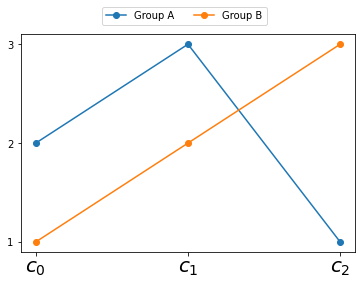

In [17]:
plot_decisions(decisions, choices)

In [18]:
winners, losers, polls, match_table = global_pairwise_winner(decisions, choices, borda_scoring)
print("Pairwise winners", winners)
print("Pairwise losers", losers)
print(polls)
print(match_table)
# pd.DataFrame({"$" + key + "$": val for key, val in eval_borda(decisions, choices, borda_scoring).items()}, index=["Borda score"])
pd.DataFrame(eval_borda(decisions, choices, borda_scoring), index=["Borda score"])

Pairwise winners ['c_2']
Pairwise losers ['c_0']
{('c_0', 'c_1'): [0, 7], ('c_0', 'c_2'): [3, 4], ('c_1', 'c_2'): [3, 4]}
[[0. 0. 0.]
 [1. 0. 0.]
 [1. 1. 0.]]


,c_0,c_1,c_2
Borda score,10,17,15


# 4.5 Ostrogorsky と Anscombe のパラドックス

本節では争点が複数存在する時に生じる２つのパラドックスについて紹介する。

単峰性と明示的な関係があるわけではないが、議論が比較的近いのでここで扱う。

民主主義社会では、有権者が直接的に政策の立案や決定に関わるのではなく、政治家の選出を通じて間接的に関わることが多い(**間接選挙**)。

*間接選挙の難点は、財政、外交、環境など多数の重要な争点が存在する時にも、個別の争点ごとにではなく、一人の候補にすべての争点を託して投票せねばならないことだ。*

しかし、選挙でかった政治家が、自らを民意の反映と位置づけて、自身のあらゆる政策を正当化するのは珍しいことではない。

Rae and Dault (1976)は、これが大きな過ちであることを、次のような例を用い指摘し、この事例を**オストロゴルスキーのパラドックス**と名付けた（Moisey Yakovlevich Ostrogorsky, 1854-1921 https://en.wikipedia.org/wiki/Moisey_Ostrogorsky#Works）


## Ostrogorsky のパラドックス

- 今、財政・外交・環境が争点になっている間接選挙を考える
- 有権者は５人
- 政党は $x$ と $y$ の２つが存在する
- それぞれの有権者は下のような選択をしているとする
- 全ての有権者にとって、３つ政策の重要さは等しいと仮定する
    - 例えば、有権者1は財政と外交では$x$を、環境では$y$を支持し、総合的には$x$を支持している事がわかる

|          | 財政 | 外交 | 環境 | 支持政党 |
|----------|------|------|------|----------|
| 有権者1  | $x$  | $x$  | $y$  | $x$      |
| 有権者2  | $x$  | $y$  | $x$  | $x$      |
| 有権者3  | $y$  | $x$  | $x$  | $x$      |
| 有権者4  | $y$  | $y$  | $y$  | $y$      |
| 有権者5  | $y$  | $y$  | $y$  | $y$      |
|          |      |      |      |          |
| 多数決   | $y$  | $y$  | $y$  | $x$      |

ここで、政党について多数決を行えば、政党$x$が勝利する。一方、テーマごとに多数決をすれば全てのテーマで$y$が勝利する。

間接選挙と、直接選挙では結果が真逆になってしまっている！

このパラドックスは、間接選挙で選ばれた政治家は全県委任されたわけでは決してないこと、そして争点が多数の場合にはテーマごとに直接選挙をしたほうが良い可能性を示唆している。

## Anscombe のパラドックス
さて、今、上の例で、テーマごとに選挙（直接選挙）して、3つのテーマとも、政党$y$の政策に決まったとしよう。
するとこの時、有権者1~3は2つのテーマに関し不満があることになる。
これは即ち、「過半数の有権者が、過半数の政策に対して不満がある」ということになる。

つまり、個別テーマについて直接選挙をしても、過半数の有権者が「全体としては好ましくない結果だ。」と感じる事態が生じうる。

これを**アンスコムのパラドックス**という。

Gertrude Elizabeth Margaret Anscombe (/ˈænskəm/; 18 March 1919 – 5 January 2001)
- https://en.wikipedia.org/wiki/G._E._M._Anscombe
- https://web.math.utk.edu/~wagner/papers/anscombe.pdf

# 4.6 64パーセント多数決と改憲
本節では、現行の状態から重要な問題を変更をする時に、何％の賛成をもって変更を認めればよいのかという問題を考察する。

改憲を題材に考えてみよう。一体改憲は何％の賛成で認められるべきなのか？

日本国憲法では、第九十六条が改憲の条件を定めている
- 衆参両院で3分の2以上、その後の国民投票で過半数の賛成が求められる。

いったいこれらの割合は妥当なものなのであろうか？


例えば、憲法の条文の一つに、表現の自由に関する、以下のものがある
```
第二十一条　集会、結社及び言論、出版その他一切の表現の自由は、これを保障する。
```
この条文を変更する方法は色々あるが、中には、自由民主党の改憲草案にあるように、この表現の自由を弱めた案も存在する

```
前項の規定に関わらず、公共及び公の秩序を害することを目的とした活動を行い、並びにそれを目的として結社をすることは、認められない。
```

このように、一つのテーマに関わる条文でも、様々な書き方が可能であり、論点も複数ある。
この事を念頭において、改憲をサイクルとの関連において論じよう。

- 現行の条文は$x$とする
- 代替案が$y$であり、過半数がこれを支持しているとする

この状況で、過半数による賛成での$x$から$y$への変更は妥当か？

実は過半数だけでは正当と見なすことはできない。なぜなら、別の条文$z$が存在して、
- 過半数の有権者は$x$から$y$への変更を望む
- 過半数の有権者は$y$から$z$への変更を望む
- 過半数の有権者は$z$から$x$への変更を望む

というサイクルが生じている可能性があるからだ。

このとき、$x$から$y$に変更することを正しいと判断できない。

では、何％なら正当であると言えるのだろうか？

この事を Caplin and Nalebuff(1988)に従い論じていこう。（概要と結果だけ）

- 論点の数: $l$
- 一つの選択肢 $x=(x_1,\dots,x_l)$
- 選択肢の全体 $X=\{x=(x_1,\dots,x_l)|\text{all possible } x\}$
- 有権者は各々最良と思う選択肢がありそこからの距離によって他の選択肢の望ましさを測る
- その他の条件は省略

何％の集票でサイクルを否定できるのか？

彼らが導き出した答えは：
$$
1 - \left( \frac{l}{l+1}\right)^l
$$
である。

この時、$l \rightarrow \infty$ とすると
$$
\begin{eqnarray}
\lim_{l \rightarrow \infty}\left(1 - \left( \frac{l}{l+1}\right)^l\right) &=& \lim_{l \rightarrow \infty}\left(1 - \frac{1}{\left(1+\frac{1}{l}\right)^l}\right)\\
    &=& 1 - \frac{1}{e}　 \approx 0.632
\end{eqnarray}
$$
である。

つまり、$l$がどのような値であっても、おおよそ$63.2%$ 以上の賛成により変更を可能とするならば、サイクルは生じ得ない。

このようなルールを、**64％多数決ルール**という。

条文により $l$ は変わるし、そもそも値がわからない事もあり得る。そうであれば、重大な条文を変更する時には、上限である 63.2% あたりを可決ラインとするのが適切であると言える。これは2/3に近い。改憲に2/3以上の議員の賛成を求めるのは理にかなっていると言える。

しかし、国民投票では、過半数の賛成となっているので、改憲条件は適切であるとは言えない。

# 4.7 Gibbard=Satterthwaite 定理

多数決のもとで有権者は、自分の票が死票となるのを避けるため次善の候補に投票することは珍しくない、
戦略的に虚偽の意思表明を行うわけである。
これは、有権者の行動が悪い訳ではなく、そうしなければ自分の意思を反映できない決定のルールのほうが上手く出来ていないと考えるべきだ。

では、耐戦略性（他者がどのような選択であれ、自分が好きな選択をしても損をしないこと）を満たす決定の仕方は存在するのだろうか？

状況によってはある。実際、単峰性がある時は中位ルールがそれであった。

しかし、一般のケースでは、単峰性は成り立たない事があるし、単峰性がなければ中位ルールも定義できない。ボルダルールも戦略的操作の影響は受ける。

この問題に答えを与えたのが、Gibbard と Satterthwaite である。

**Theorem: 耐戦略性と満場一致性を満たすルールは独裁制だけである。**

用語：
- 独裁制
    - ある特定の個人が存在して、他人がどのような選好を持っていようがその個人にとって一位の選択肢が社会の決定となる。
    - この個人を **独裁** と呼ぶ。
- 満場一致性
    - 他の選択肢に満場一致で負ける選択肢は、社会の決定とならない。
    - 独裁制は満場一致性を満たす。
        - 独裁者が選んだ選択肢は、それが選ばれるし、それ以外の選択肢は選ばれることはないので、満場一致で負けていたとしてもそれが選ばれることはない
        
## 定理の簡単な場合の証明
- 有権者2人、選択肢3つ
    - 個人1,2 と $x$, $y$, $z$ で表す。
- ３つの選択肢の順序付けは6通りある。
    - 2人の個人の順序付けの全ての組み合わせは36通りある
    - 全ての2人の順序付けの組み合わせを、以下のように表で書き表す

| 個人1\個人2  |(a) xyz |(b) xzy |(c) yxz |(d) yzx |(e) zxy |(f) zyx |
|--------------|--------|--------|--------|--------|--------|--------|
| (a) xyz      |        |        |        |        |        |        |
| (b) xzy      |        |        |        |        |        |        |
| (c) yxz      |        |        |        |        |        |        |
| (d) yzx      |        |        |        |        |        |        |
| (e) zxy      |        |        |        |        |        |        |
| (f) zyx      |        |        |        |        |        |        |

これから、これら一つ一つの状況で、どの選択肢が選ばれるかを書き込んでいく

まず満場一致性から、二人とも一位の選択肢が同じ場合はその選択肢を書く

| 個人1\個人2 | (a)xyz | (b)xzy | (c)yxz | (d)yzx | (e)zxy | (f)zyx |
|-------------|--------|--------|--------|--------|--------|--------|
| (a)xyz      | x      | x      |        |        |        |        |
| (b)xzy      | x      | x      |        |        |        |        |
| (c)yxz      |        |        | y      | y      |        |        |
| (d)yzx      |        |        | y      | y      |        |        |
| (e)zxy      |        |        |        |        | z      | z      |
| (f)zyx      |        |        |        |        | z      | z      |

(a,d) の組み合わせを考えると{xyz}, {yzx}なので、z は y に満場一致で負けているので、この場合、 x,y のどちらかが選ばれる。

ここでは、x が選ばれると仮定しよう（y が選ばれるときも同様の議論ができる。その場合、独裁者が逆になる）

| 個人1\個人2 | (a)xyz | (b)xzy | (c)yxz | (d)yzx | (e)zxy | (f)zyx |
|-------------|--------|--------|--------|--------|--------|--------|
| (a)xyz      | x      | x      |        | x      |        |        |
| (b)xzy      | x      | x      |        |        |        |        |
| (c)yxz      |        |        | y      | y      |        |        |
| (d)yzx      |        |        | y      | y      |        |        |
| (e)zxy      |        |        |        |        | z      | z      |
| (f)zyx      |        |        |        |        | z      | z      |

次に (b,d) を見てみよう。もしここで x 以外が選ばれたら、個人1は(b)でなく(a)を選択することによって、xを実現でき得をしてしまう。

よって耐戦略性から、ここでは x が選ばれていなければならない。

次に (e,d) そ見てみよう。満場一致性より、ここは x ではない。もし y ならば、個人1は(a)と申告すれば y よりはましな x を実現できるので、耐戦略性に矛盾する。よって、ここでは z が選ばれなければならない。

| 個人1\個人2 | (a)xyz | (b)xzy | (c)yxz | (d)yzx | (e)zxy | (f)zyx |
|-------------|--------|--------|--------|--------|--------|--------|
| (a)xyz      | x      | x      |        | x      |        |        |
| (b)xzy      | x      | x      |        | x      |        |        |
| (c)yxz      |        |        | y      | y      |        |        |
| (d)yzx      |        |        | y      | y      |        |        |
| (e)zxy      |        |        |        | z      | z      | z      |
| (f)zyx      |        |        |        |        | z      | z      |

次に、(f,d)を見てみよう。もしここで、z 以外が選ばれていたら、個人1は(e)と申告すれば z が選ばれるので、耐戦略性と矛盾。よって、z が選ばれなければならない。

| 個人1\個人2 | (a)xyz | (b)xzy | (c)yxz | (d)yzx | (e)zxy | (f)zyx |
|-------------|--------|--------|--------|--------|--------|--------|
| (a)xyz      | x      | x      |        | x      |        |        |
| (b)xzy      | x      | x      |        | x      |        |        |
| (c)yxz      |        |        | y      | y      |        |        |
| (d)yzx      |        |        | y      | y      |        |        |
| (e)zxy      |        |        |        | z      | z      | z      |
| (f)zyx      |        |        |        | z      | z      | z      |

票を見て分かるように、個人2が(d)と申告する限りにおいては、個人1が一位する選択肢が必ず社会的選択肢になっている。
つまり、個人1が独裁者である雰囲気が漂ってきた。

次は、個人2の視点からマス目を埋めていこう。

(a,d)では、個人2にとって最悪の x が選ばれている。 そこで、(a,-)行の他の場合で、 x 以外の選択肢が選ばれれば、個人2は虚偽に得をしてしまう。
よって他の(a,-)行でも x が選ばれなければならない。

同様のことが (b,-)行でも起こる。よって

| 個人1\個人2 | (a)xyz | (b)xzy | (c)yxz | (d)yzx | (e)zxy | (f)zyx |
|-------------|--------|--------|--------|--------|--------|--------|
| (a)xyz      | x      | x      | x      | x      | x      | x      |
| (b)xzy      | x      | x      | x      | x      | x      | x      |
| (c)yxz      |        |        | y      | y      |        |        |
| (d)yzx      |        |        | y      | y      |        |        |
| (e)zxy      |        |        |        | z      | z      | z      |
| (f)zyx      |        |        |        | z      | z      | z      |

となる。

次いで、(f,c)を見てみよう。満場一致性から、xは選ばれない。

もしここで、 y が選ばれるならば、(f,d)の状況の時に、個人2が(c)に申告を変える事により得をしてしまう。よって、ここでは、z が選ばれなければならない。

また、(e,c)でも、z 以外が選ばれるなら、個人1は(f)に変更することにより得をしてしまう。よって、z が選ばれなければならない。
更に、(e,c)や(f,c)の時に、個人2に(a)や(b)と選択させないためには、全ての場合で　z が選ばれなければならない。

| 個人1\個人2 | (a)xyz | (b)xzy | (c)yxz | (d)yzx | (e)zxy | (f)zyx |
|-------------|--------|--------|--------|--------|--------|--------|
| (a)xyz      | x      | x      | x      | x      | x      | x      |
| (b)xzy      | x      | x      | x      | x      | x      | x      |
| (c)yxz      |        |        | y      | y      |        |        |
| (d)yzx      |        |        | y      | y      |        |        |
| (e)zxy      | z      | z      | z      | z      | z      | z      |
| (f)zyx      | z      | z      | z      | z      | z      | z      |

次いで、(d,a)を見よう。満場一致性から z は選ばれない。

もしここで、x が選ばれると、 個人1は(e)や(f)を申告して得をしてしまう。よって、y でなければならない。

一方、(c,a)でもし y 以外が選ばれるなら、個人1は (d) を申告すれば得をするので、ここも y でなければならない。

| 個人1\個人2 | (a)xyz | (b)xzy | (c)yxz | (d)yzx | (e)zxy | (f)zyx |
|-------------|--------|--------|--------|--------|--------|--------|
| (a)xyz      | x      | x      | x      | x      | x      | x      |
| (b)xzy      | x      | x      | x      | x      | x      | x      |
| (c)yxz      | y      |        | y      | y      |        |        |
| (d)yzx      | y      |        | y      | y      |        |        |
| (e)zxy      | z      | z      | z      | z      | z      | z      |
| (f)zyx      | z      | z      | z      | z      | z      | z      |

(c,b)を見てみよう。満場一致性から z は選ばれない。x が選ばれると(c,a)で個人2が(a)から(b)に変えることで得をしてしまうので、耐戦略性に矛盾。よって、y が選ばれる。そして、ここが y である事により(d,b)で y 以外が選ばれると個人1は (d)->(c)とすることで得をしてしまうのでだめ。よって、ここも y。

| 個人1\個人2 | (a)xyz | (b)xzy | (c)yxz | (d)yzx | (e)zxy | (f)zyx |
|-------------|--------|--------|--------|--------|--------|--------|
| (a)xyz      | x      | x      | x      | x      | x      | x      |
| (b)xzy      | x      | x      | x      | x      | x      | x      |
| (c)yxz      | y      | y      | y      | y      |        |        |
| (d)yzx      | y      | y      | y      | y      |        |        |
| (e)zxy      | z      | z      | z      | z      | z      | z      |
| (f)zyx      | z      | z      | z      | z      | z      | z      |

(c,-)行、(d,-)行の残りの升目についても同様に、耐戦略性との矛盾から、y を選ばなければならない事がわかるので結局

| 個人1\個人2 | (a)xyz | (b)xzy | (c)yxz | (d)yzx | (e)zxy | (f)zyx |
|-------------|--------|--------|--------|--------|--------|--------|
| (a)xyz      | x      | x      | x      | x      | x      | x      |
| (b)xzy      | x      | x      | x      | x      | x      | x      |
| (c)yxz      | y      | y      | y      | y      | y      | y      |
| (d)yzx      | y      | y      | y      | y      | y      | y      |
| (e)zxy      | z      | z      | z      | z      | z      | z      |
| (f)zyx      | z      | z      | z      | z      | z      | z      |

となるが、この結果を見ると、どのマス目にも個人1が一位とした選択肢が入っている。すなわち、個人1が独裁者であることになる。

この証明の発端は (a,d)において選ばれる選択肢が、個人1に取ってより好ましい x とした事であった。その時に個人1が独裁者となるわけだ。

もし、ここで y を選んでいれば、上の議論と同様の証明で、 個人2が独裁者になることが示せる。また満場一致性から z とは書けないのであった。

よって、耐戦略性と満場一致性を求めると、どちらかの個人が独裁者になる。